<a href="https://colab.research.google.com/github/sennycho/Kaggle/blob/main/AlienvsPredator_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 에일리언 vs 프레데터 데이터셋
* https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images
* 케글 로그인 -> 계정 클릭 -> 프로필 -> Account -> API항목에 Create New Token -> kaggle.json 다운로드 됨
* {"username":"sennycho","key":"c2f8e1539d07ee66f4c21e31db80e074"}

In [ ]:
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'sennycho'  # username
os.environ['KAGGLE_KEY'] = 'c2f8e1539d07ee66f4c21e31db80e074'  # key

In [ ]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images
!unzip -q alien-vs-predator-images.zip

 35% 5.00M/14.1M [00:00<00:00, 49.3MB/s]
100% 14.1M/14.1M [00:00<00:00, 97.5MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. 이미지 증강 기법(Image Augmentation)
* 원본이미지(데이터)를 조작하여 원본과는 크고 작은 변화를 가진 이미지를 생성
  - 일반적으로 모델 성능이 좋아짐
  - Over fitting 방지
* https://pytorch.org/vision/master/transforms.html


In [ ]:
data_transforms ={
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10 , scale =(0.8,12)),
        transforms.RandomHorizontalFlip(), # 좌우반전
        transforms.ToTensor(),
    ]),
    'validation':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [ ]:
# ImageFolder(): 함수쓴
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

694 200


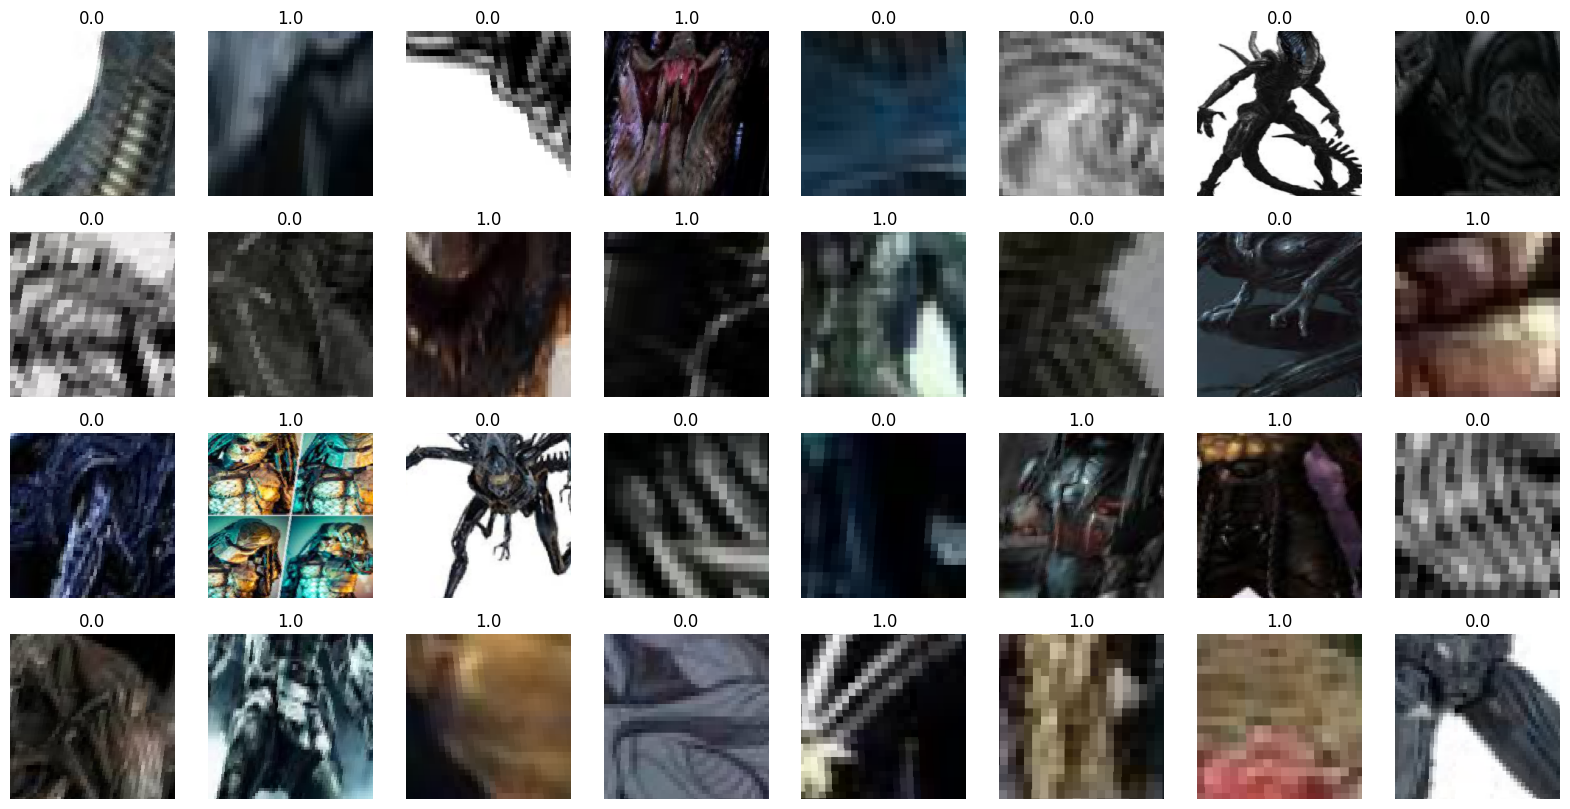

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))    # permute(): 주어진 리스트의 원소를 모든 가능한 순열로 재배열하는 함수.
    ax.axis('off')

# 3. 전이 학습(Transfer Learning)
* 하나의 작업을 위해 훈련된 모델을 유사 작업 수행 모델의 시작점으로 활용하는 딥러닝 접근법
* 신경망은 처음부터 새로 학습하는것 보다 전이 학습을 통해 업데이트하고 재학습 하는 편이 더 빠르고 간편함
* 전이학습은 여러 응용분야중에서도 특히 검출, 영상인식, 음성인식, 검색분야에 마ㅓㄶ이 사용된다

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

### 3-1. 전이학습의 고려할 점
* 크기: 모델크기의 중요성은 모델을 배포할 위치와 방법에 따라 달라짐
* 정확도: 재훈련 전의 모델 성능은 어느정도인지 확인이 필요
* 예측 속도:  하드웨어 및 배치 크기와 같은 다른 딥러닝 요소는 물론 선택된 모델의 아키텍쳐와 모델 크기에 따라서도 달라짐

![](https://kr.mathworks.com/discovery/transfer-learning/_jcr_content/mainParsys/image.adapt.full.medium.jpg/1634621302937.jpg)

# 4. 사전 학습된 ResNet50 모델
* [파이토치에서 제공하는 사전학습 모델들](https://pytorch.org/vision/stable/models.html)

![](https://i.stack.imgur.com/gI4zT.png)

### 4-1. 이미지넷(ImageNet)
* 이미지 데이터베이스
* 1000개의 동물과 사물 이미지를 포함

![](https://i.imgur.com/5Rz5s8e.png)


In [ ]:
# model = models.resnet50(pretrained=True).to(device)   => 미리 학습된것을 쓰겠다는 뜻
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 4-2. Freeze Layers
* 특징을 뽑아내는 CNN의 앞쪽 컨볼루션 레이어들은 학습을 하지 않도록 설정
* 출력 부분의 레이어(fc)를 다시 분류에 맞게 설정
(이미지를 분류한 결과물이 우리는 0 또는 1이잖아 그런데 저 모델자체가 원래 0 부터 999 까지 나오도록 설정 되어있어 그걸 재설정 한거)

In [ ]:
for param in model.parameters():
    param.requires_grad = False  # 가져온 파라미터(W, b)를 업데이트하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# 학습: fc부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()      # eval()하면 모델이 검증모드 된다
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss.item()
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')


train     : Epoch    1/10, Loss: 0.7305, Accuracy: 53.58%
validation: Epoch    1/10, Loss: 0.6586, Accuracy: 77.68%
train     : Epoch    2/10, Loss: 0.6411, Accuracy: 69.93%
validation: Epoch    2/10, Loss: 0.6019, Accuracy: 73.21%
train     : Epoch    3/10, Loss: 0.5837, Accuracy: 70.70%
validation: Epoch    3/10, Loss: 0.5359, Accuracy: 77.68%
train     : Epoch    4/10, Loss: 0.5454, Accuracy: 73.05%
validation: Epoch    4/10, Loss: 0.4823, Accuracy: 80.36%
train     : Epoch    5/10, Loss: 0.5335, Accuracy: 74.11%
validation: Epoch    5/10, Loss: 0.4685, Accuracy: 81.25%
train     : Epoch    6/10, Loss: 0.5099, Accuracy: 74.74%
validation: Epoch    6/10, Loss: 0.4894, Accuracy: 75.45%
train     : Epoch    7/10, Loss: 0.5142, Accuracy: 74.48%
validation: Epoch    7/10, Loss: 0.6489, Accuracy: 65.18%
train     : Epoch    8/10, Loss: 0.5455, Accuracy: 71.86%
validation: Epoch    8/10, Loss: 0.4368, Accuracy: 81.25%
train     : Epoch    9/10, Loss: 0.5316, Accuracy: 71.99%
validation: Ep

In [ ]:
torch.save(model.state_dict(), 'model.h5')

In [ ]:
model = models.resnet50().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [ ]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()      # eval()하면 모델이 검증모드 된다
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss.item()
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10, Loss: 0.7783, Accuracy: 43.83%
validation: Epoch    1/10, Loss: 0.6898, Accuracy: 55.36%
train     : Epoch    2/10, Loss: 0.7042, Accuracy: 50.63%
validation: Epoch    2/10, Loss: 0.6936, Accuracy: 55.36%
train     : Epoch    3/10, Loss: 0.7032, Accuracy: 50.37%
validation: Epoch    3/10, Loss: 0.6881, Accuracy: 55.36%
train     : Epoch    4/10, Loss: 0.6888, Accuracy: 53.07%
validation: Epoch    4/10, Loss: 0.7139, Accuracy: 44.64%
train     : Epoch    5/10, Loss: 0.6913, Accuracy: 52.76%
validation: Epoch    5/10, Loss: 0.6794, Accuracy: 57.59%
train     : Epoch    6/10, Loss: 0.6939, Accuracy: 49.23%
validation: Epoch    6/10, Loss: 0.6717, Accuracy: 56.70%
train     : Epoch    7/10, Loss: 0.6891, Accuracy: 56.87%
validation: Epoch    7/10, Loss: 0.6799, Accuracy: 56.70%
train     : Epoch    8/10, Loss: 0.6942, Accuracy: 53.46%
validation: Epoch    8/10, Loss: 0.6697, Accuracy: 62.95%
train     : Epoch    9/10, Loss: 0.6884, Accuracy: 56.70%
validation: Ep

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('model.h5'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

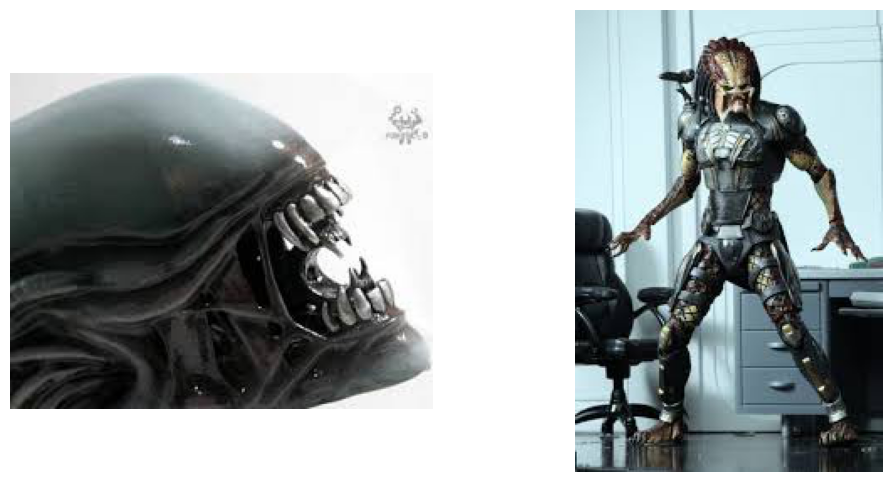

In [ ]:
# 테스트
from PIL import Image

img1 = Image.open('data/validation/alien/32.jpg')
img2 = Image.open('data/validation/predator/45.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [ ]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [ ]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [ ]:
y_pred = model(test_batch)
y_pred

tensor([[0.2751],
        [0.6671]], device='cuda:0', grad_fn=<SigmoidBackward0>)

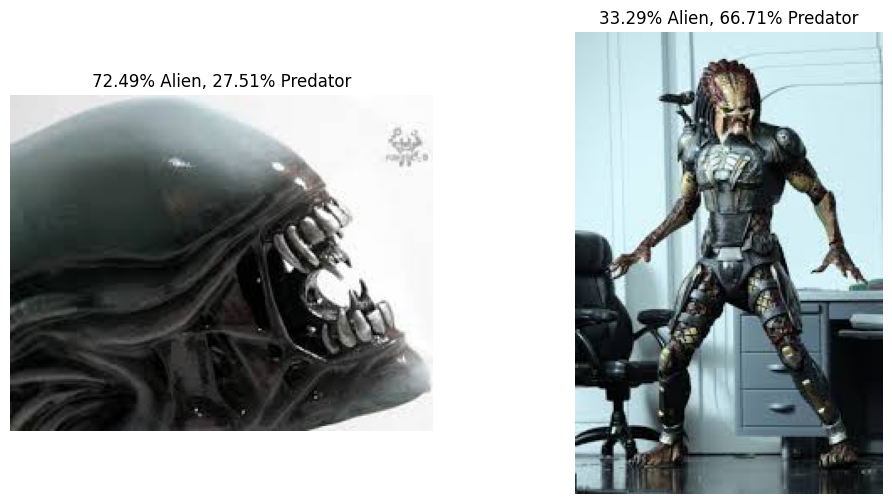

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0]) * 100:.2f}% Alien, {y_pred[0, 0] * 100:.2f}% Predator')
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title(f'{(1-y_pred[1, 0]) * 100:.2f}% Alien, {y_pred[1, 0] * 100:.2f}% Predator')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

### 과제
* 전이학습으로 강아지와 고양이 구분하기
https://www.kaggle.com/c/dogs-vs-cats